In [1]:
from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from torchray_extremal_perturbation_sequence import extremal_perturbation, contrastive_reward, simple_reward
from torchray.utils import get_device

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from sklearn import preprocessing
import pandas as pd

class MySequence :
    def __init__(self) :
        self.dummy = 1

import tensorflow as tf

import tensorflow.keras

tf.keras.utils.Sequence = MySequence

from sequence_logo_helper import plot_dna_logo, dna_letter_at


In [11]:
#Load data

dataset_name = "optimus5_synth"

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2


#Train data
e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
y_train = np.array(e_train['scaled_rl'].values)
y_train = np.reshape(y_train, (y_train.shape[0],1))

y_train = (y_train >= 0.)
y_train = np.concatenate([1. - y_train, y_train], axis=1)

print("x_train.shape = " + str(x_train.shape))
print("y_train.shape = " + str(y_train.shape))

#Test data
allFiles = ["optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_1_start_2_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_2_stop_variable_loc_512.csv"]

x_tests = []

for csv_to_open in allFiles :
    
    #Load dataset for benchmarking 
    dataset_name = csv_to_open.replace(".csv", "")
    benchmarkSet = pd.read_csv(csv_to_open)
    
    seq_e_test = one_hot_encode(benchmarkSet, seq_len=50)
    x_test = seq_e_test[:, None, ...]
    
    print(x_test.shape)
    
    x_tests.append(x_test)

x_test = np.concatenate(x_tests, axis=0)
y_test = -1. * np.ones((x_test.shape[0], 1))

y_test = (y_test >= 0.)
y_test = np.concatenate([1. - y_test, y_test], axis=1)

print("x_test.shape = " + str(x_test.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (15008, 1, 50, 4)
y_train.shape = (15008, 2)
(512, 1, 50, 4)
(512, 1, 50, 4)
(512, 1, 50, 4)
(512, 1, 50, 4)
x_test.shape = (2048, 1, 50, 4)
y_test.shape = (2048, 2)


In [16]:
#Load predictor model

class CNNClassifier(nn.Module) :
    
    def __init__(self, batch_size) :
        super(CNNClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 120, kernel_size=(1, 8), padding=(0, 4))
        self.conv2 = nn.Conv2d(120, 120, kernel_size=(1, 8), padding=(0, 4))
        self.conv3 = nn.Conv2d(120, 120, kernel_size=(1, 8), padding=(0, 4))
        
        self.fc1 = nn.Linear(in_features=50 * 120, out_features=40)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=40, out_features=1)
        
        self.batch_size = batch_size
        self.use_cuda = True if torch.cuda.is_available() else False
        
    def forward(self, x):
        
        #x = x.transpose(1, 2)
        
        x = F.relu(self.conv1(x))[..., 1:]
        x = F.relu(self.conv2(x))[..., 1:]
        x = F.relu(self.conv3(x))[..., 1:]
        
        x = x.transpose(1, 3)
        x = x.reshape(-1, 50 * 120)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        #Transform sigmoid logits to 2-input softmax scores
        x = torch.cat([-1 * x, x], axis=1)
        
        return x

model_pytorch = CNNClassifier(batch_size=1)
_ = model_pytorch.load_state_dict(torch.load("optimusRetrainedMain_pytorch.pth"))


In [17]:
#Create pytorch input tensor

x_test_pytorch = Variable(torch.FloatTensor(np.transpose(x_test, (0, 3, 1, 2))))
x_test_pytorch = x_test_pytorch.cuda() if model_pytorch.use_cuda else x_test_pytorch

digit_test = np.array(np.argmax(y_test, axis=1), dtype=np.int)


In [18]:
#Predict using pytorch model
device = get_device()

model_pytorch.to(device)

model_pytorch.eval()

y_pred_pytorch = np.concatenate([model_pytorch(x_test_pytorch[i:i+1]).data.cpu().numpy() for i in range(x_test.shape[0])], axis=0)

digit_pred_test = np.argmax(y_pred_pytorch, axis=-1)

print("Test accuracy = " + str(round(np.sum(digit_test == digit_pred_test) / digit_test.shape[0], 4)))


Test accuracy = 0.9805


In [19]:

device = get_device()

model_pytorch.to(device)
x_test_pytorch = x_test_pytorch.to(device)


In [20]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()

class IdentityEncoder :
    
    def __init__(self, seq_len, channel_map) :
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

#Initialize sequence encoder

seq_length = 50

residue_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

encoder = IdentityEncoder(seq_length, residue_map)


In [21]:
y_pred_pytorch[:10]

array([[ 0.74246424, -0.74246424],
       [ 1.3410296 , -1.3410296 ],
       [ 0.7005814 , -0.7005814 ],
       [ 1.1614575 , -1.1614575 ],
       [ 0.78864264, -0.78864264],
       [ 0.7068927 , -0.7068927 ],
       [ 0.55630714, -0.55630714],
       [ 0.6454755 , -0.6454755 ],
       [ 0.98291814, -0.98291814],
       [ 0.69674027, -0.69674027]], dtype=float32)

extremal_perturbation:
- target: 0
- areas: [0.2]
- variant: preserve
- max_iter: 800
- step/sigma: 3, 3
- image size: [1, 4, 1, 50]
- reward function: contrastive_reward
- Perturbation:
  - type: blur
  - num_levels: 8
  - pyramid shape: [8, 4, 1, 50]
- mask resolution:
  torch.Size([1, 1, 1, 17])
[0001/0800] [area:0.20 loss:1.42 reg:-155.48]
torch.Size([1, 7, 55])
torch.Size([1, 4, 50])


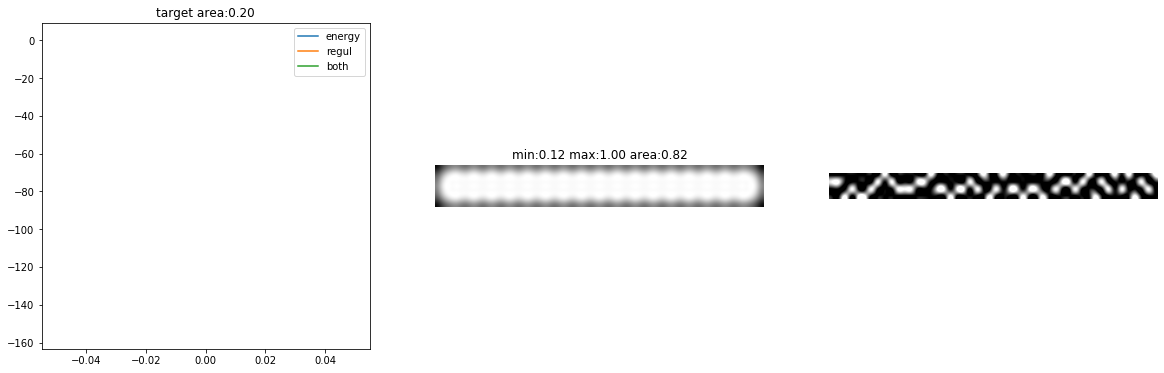

[0200/0800] [area:0.20 loss:1.50 reg:-14.32]
torch.Size([1, 7, 55])
torch.Size([1, 4, 50])


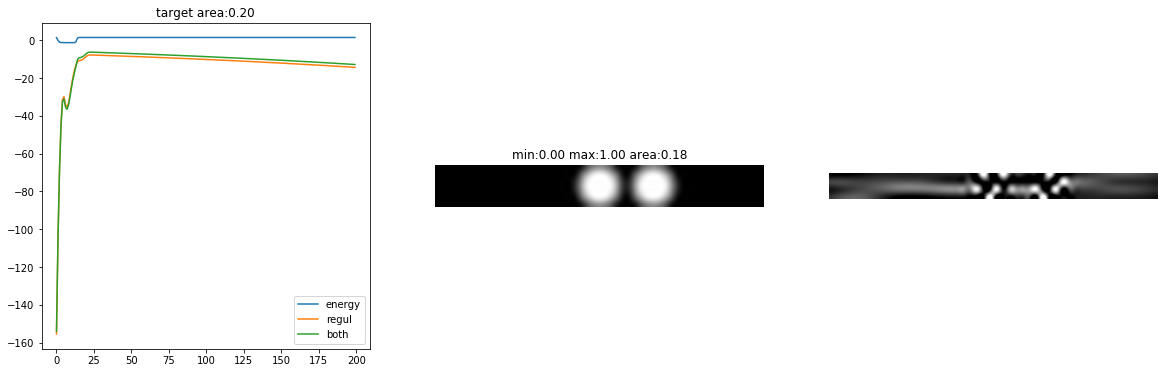

[0399/0800] [area:0.20 loss:1.50 reg:-28.69]
torch.Size([1, 7, 55])
torch.Size([1, 4, 50])


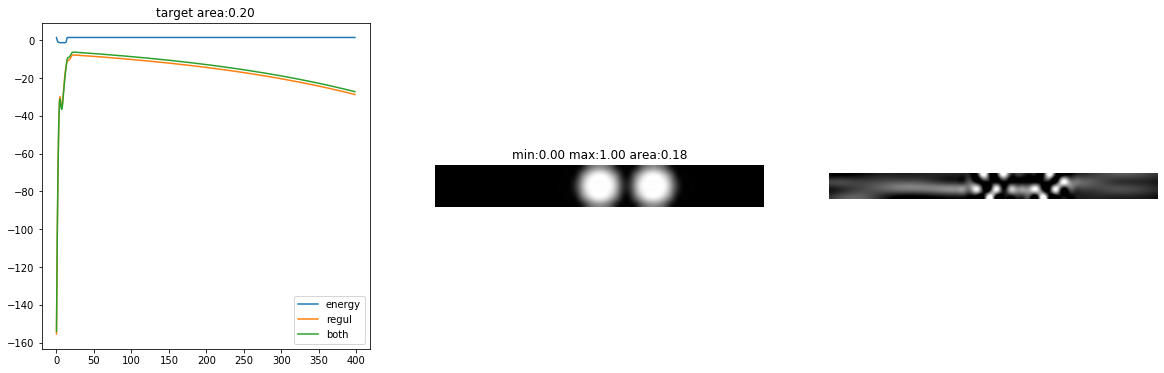

[0598/0800] [area:0.20 loss:1.50 reg:-57.51]
torch.Size([1, 7, 55])
torch.Size([1, 4, 50])


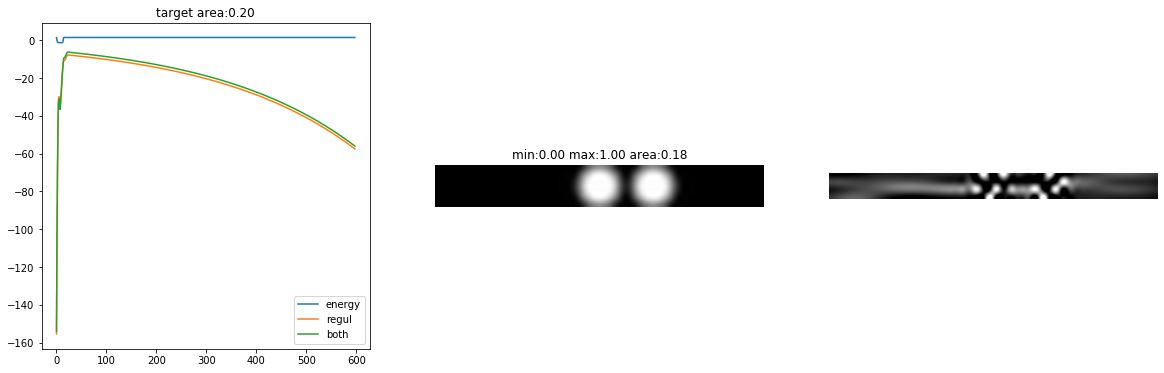

[0797/0800] [area:0.20 loss:1.50 reg:-115.26]
torch.Size([1, 7, 55])
torch.Size([1, 4, 50])


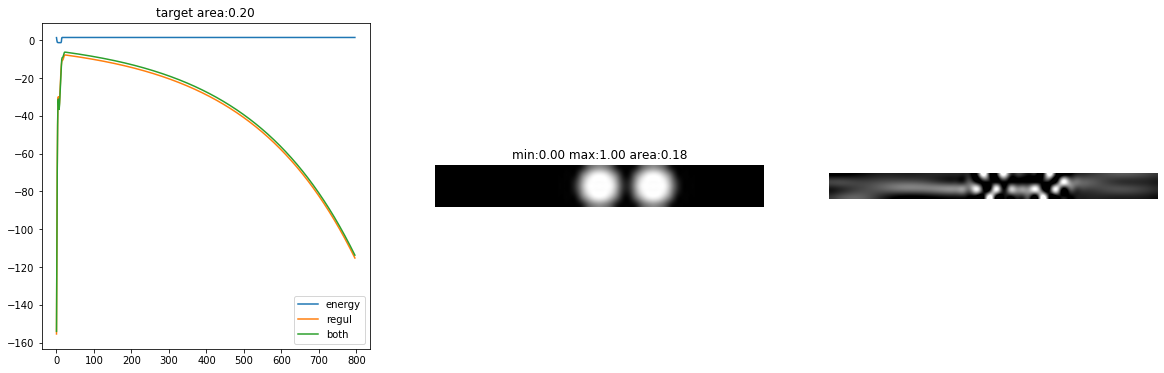

[0800/0800] [area:0.20 loss:1.50 reg:-116.47]
torch.Size([1, 7, 55])
torch.Size([1, 4, 50])


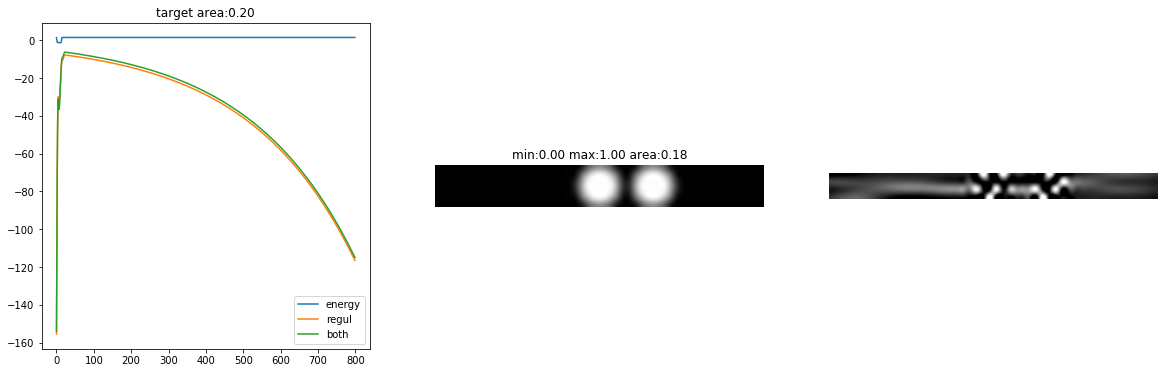

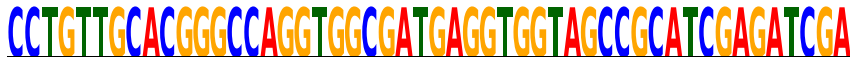

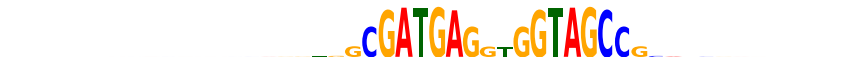

In [24]:
#Execute method on test set

i = 0

area = 0.2
variant_mode = "preserve"
perturbation_mode = "blur"

masks = []

m, _ = extremal_perturbation(
    model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
    reward_func=contrastive_reward,
    debug=True,
    jitter=False,
    areas=[area],
    variant=variant_mode,
    perturbation=perturbation_mode,
    num_levels=8,
    step=3,
    sigma=3
)

imp_s = np.tile(m[0, 0, :, :].cpu().numpy(), (4, 1)) * x_test[i, 0, :, :].T

score_clip = None

plot_dna_logo(x_test[i, 0, :, :], sequence_template='N'*50, figsize=(12, 1), plot_start=0, plot_end=50)

plot_importance_scores(imp_s, encoder.decode(x_test[i, 0, :, :]), figsize=(12, 1), score_clip=score_clip, sequence_template='N'*50, plot_start=0, plot_end=50)


In [25]:
#Execute method on test set

n_to_test = x_test.shape[0]

area = 0.2
variant_mode = "preserve"
perturbation_mode = "blur"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=3
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...
Processing example 1900...
Processing example 2000...


Test sequence 0:


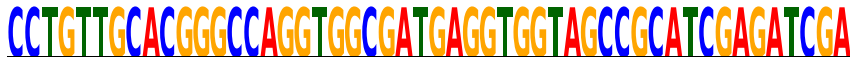

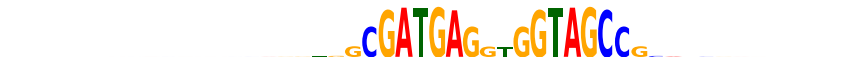

Test sequence 1:


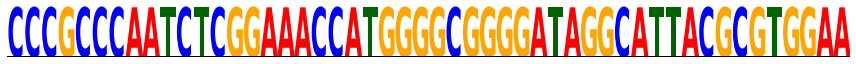

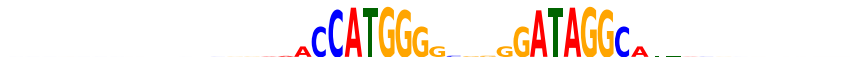

Test sequence 2:


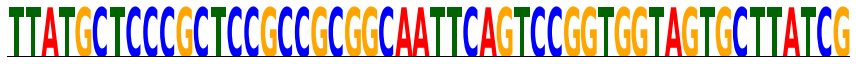

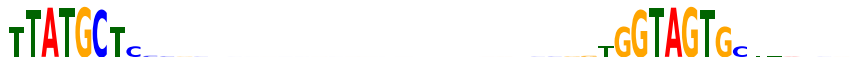

Test sequence 3:


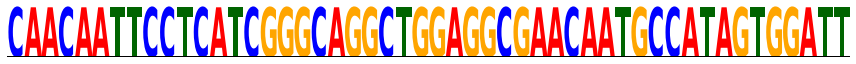

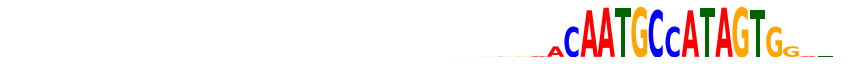

Test sequence 4:


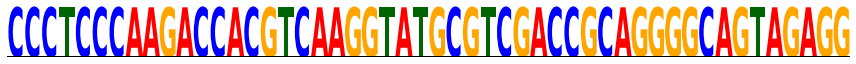

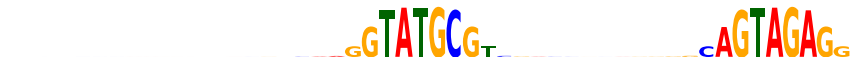

In [26]:
#Visualize a few images

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    imp_s = np.tile(importance_scores_test[plot_i, :, :, 0], (4, 1)) * x_test[plot_i, 0, :, :].T

    score_clip = None

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template='N'*50, figsize=(12, 1), plot_start=0, plot_end=50)

    plot_importance_scores(imp_s, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=score_clip, sequence_template='N'*50, plot_start=0, plot_end=50)



In [27]:
#Save predicted importance scores

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[0:512, ...])

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_1_start_2_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[512:1024, ...])

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[1024:1536, ...])

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_2_start_2_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[1536:2048, ...])


In [28]:
#Execute method on test set

n_to_test = x_test.shape[0]

area = 0.2
variant_mode = "preserve"
perturbation_mode = "fade"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=3
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...
Processing example 1900...
Processing example 2000...


Test sequence 0:


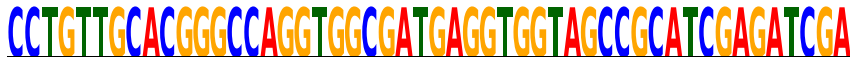

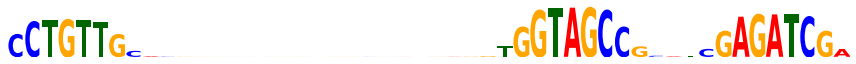

Test sequence 1:


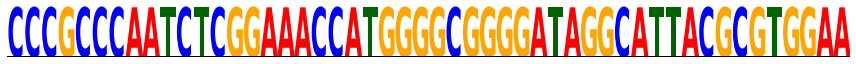

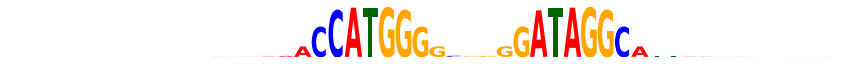

Test sequence 2:


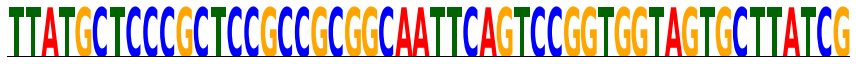

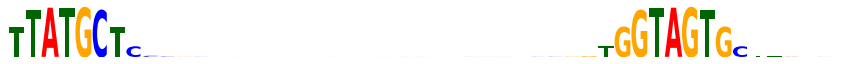

Test sequence 3:


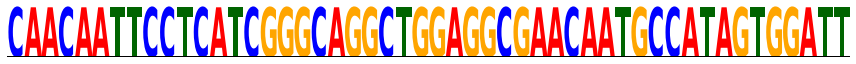

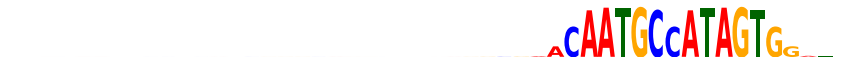

Test sequence 4:


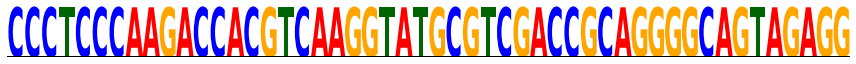

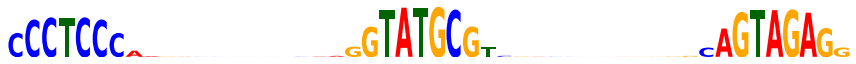

In [29]:
#Visualize a few images

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    imp_s = np.tile(importance_scores_test[plot_i, :, :, 0], (4, 1)) * x_test[plot_i, 0, :, :].T

    score_clip = None

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template='N'*50, figsize=(12, 1), plot_start=0, plot_end=50)

    plot_importance_scores(imp_s, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=score_clip, sequence_template='N'*50, plot_start=0, plot_end=50)



In [30]:
#Save predicted importance scores

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[0:512, ...])

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_1_start_2_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[512:1024, ...])

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[1024:1536, ...])

model_name = "extremal_" + "optimus5_synthetic_random_insert_if_uorf_2_start_2_stop_variable_loc_512" + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")
np.save(model_name + "_importance_scores_test", importance_scores_test[1536:2048, ...])
